<img src='sharif_logo.png' alt="SUT logo" width=150 height=150 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
 Deep Learning <br>
<font color=2565AE size=5>
Computer Engineering Department - Spring 2025  <br>
<font color=3C99D size=5>
          Homework 3: Practical - Oil Price Forecasting
 <br>
<font color=696880 size=4>
            Designer: Mohammad Amanlou
    
    

# 🛢️ Oil Price Prediction using Time Series Models 📈

This notebook is designed for students to complete tasks related to oil price prediction using different machine learning models. 🚀

## 📚 References
- 📊 [Dataset: Yahoo Finance - CL=F](https://finance.yahoo.com/quote/CL=F/history/)
- 📄 [Reference Paper](https://www.ijournalse.org/index.php/ESJ/article/view/21497)

## 1️⃣ Introduction
🔍 One of the most common applications of recurrent neural networks is **time series forecasting**. In this assignment, you will predict **crude oil prices** using four different methods. 💡

## 2️⃣ Dataset and Preprocessing

### 📥 2.1 Download Dataset
📌 Download the dataset from **Yahoo Finance** for `CL=F` from **2010 to the present**.
[Yahoo Finance - CL=F](https://finance.yahoo.com/quote/CL=F/history/)

### 🎯 2.2 Select Features
✅ Select the `Adj Close` column as the **main feature**.

### ⚠️ 2.3 Handle Missing Data
- Some dates have missing values (`null`). Additionally, **remove 10% of the recorded values randomly**.
- Implement methods to **replace missing values** and complete the dataset.

🛠 *Your task:* Implement the missing data handling methods below.

In [4]:
import yfinance as yf
import pandas as pd

data = yf.download("CL=F", start="2010-01-01", end="2024-12-19")

date_range = pd.date_range(start="2010-01-01", end="2024-12-19", freq="D")
data = data.reindex(date_range)
data.index.name = "Date"

missing_dates = data[data.isnull().any(axis=1)].index
print("\nNum of missing dates:")
print(len(missing_dates))
print("Number of dates with valid data:")
print(len(data) - len(missing_dates))

data.to_csv("crude_oil_prices.csv")

adj_close_data = data[['Adj Close']]
adj_close_data.to_csv("crude_oil_adj_close.csv")
print("\n\nthe data is like that:")
print(adj_close_data.head())

[*********************100%***********************]  1 of 1 completed


Num of missing dates:
1703
Number of dates with valid data:
3764


the data is like that:
            Adj Close
Date                 
2010-01-01        NaN
2010-01-02        NaN
2010-01-03        NaN
2010-01-04  81.510002
2010-01-05  81.769997


In [5]:
# Introduce random null
import numpy as np
non_null_indices = data[data['Adj Close'].notnull()].index
np.random.seed(42)
num_random_nulls = int(len(data) * 0.1)
random_indices = np.random.choice(non_null_indices, size=num_random_nulls, replace=False)
data.loc[random_indices, 'Adj Close'] = np.nan

In [6]:
# Identify missing dates and null values
missing_data = data[data.isnull().any(axis=1)]
print("Num of missing dates:")
print(len(missing_data))
print("Num of all dates:")
print(len(data))

Num of missing dates:
2249
Num of all dates:
5467


In [7]:
# Fill missing values
filled_data = data[['Adj Close']].copy()
filled_data['Adj Close'] = filled_data['Adj Close'].interpolate(method='linear')
filled_data['Adj Close'] = filled_data['Adj Close'].fillna(method='bfill').fillna(method='ffill')


<ipython-input-7-89666a73ef11>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_data['Adj Close'] = filled_data['Adj Close'].fillna(method='bfill').fillna(method='ffill')


### ✂️ 2.4 Train-Test Split and Normalization
- **Split** the dataset into **training and test sets** based on the ratio given in the reference paper.
- **Normalize** the data.

📄 [Reference Paper](https://www.ijournalse.org/index.php/ESJ/article/view/21497)

🛠 *Your task:* Implement the splitting and normalization below.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
train_data, test_data = train_test_split(filled_data, test_size=0.3, shuffle=False)
scaler = MinMaxScaler()
train_data['Adj Close'] = scaler.fit_transform(train_data[['Adj Close']])
test_data['Adj Close'] = scaler.transform(test_data[['Adj Close']])
print("Training data sample:")
print(train_data.head())
print("Testing data sample:")
print(test_data.head())

Training data sample:
            Adj Close
Date                 
2010-01-01   0.786091
2010-01-02   0.786091
2010-01-03   0.786091
2010-01-04   0.786091
2010-01-05   0.787807
Testing data sample:
            Adj Close
Date                 
2020-06-23   0.514648
2020-06-24   0.499076
2020-06-25   0.503761
2020-06-26   0.502243
2020-06-27   0.503530


### 📊 2.5 Data Visualization
- **Plot a histogram** similar to **Figure 6** in the reference paper, showing the **distribution of oil prices**.

🛠 *Your task:* Implement the histogram plot below.

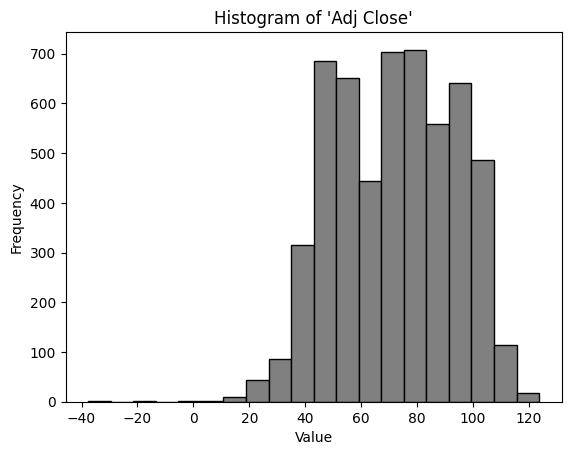

In [9]:
# Plot histogram of 'Adj Close'
import matplotlib.pyplot as plt
plt.hist(filled_data['Adj Close'], bins=20, color='gray', edgecolor='black')
plt.title("Histogram of 'Adj Close'")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

## 3️⃣ Implementing Deep Learning Models 🤖

The reference paper utilizes **four models** for time series forecasting:
- `RNN`
- `LSTM`
- `Bi-LSTM`
- `GRU`

📌 **Train** each model using the **hyperparameters** given in **Table 4** of the paper.
📌 Use `Mean Square Error (MSE)` as the **loss function**.

📄 [Reference Paper](https://www.ijournalse.org/index.php/ESJ/article/view/21497)

🛠 *Your task:* Implement these models below.

In [10]:
# Prepare data for time series models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

def create_sequences(data, window_size):
    sequences, targets = [], []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        targets.append(data[i + window_size])
    return np.array(sequences), np.array(targets)

window_size = 50
train_sequences, train_targets = create_sequences(train_data['Adj Close'].values, window_size)
test_sequences, test_targets = create_sequences(test_data['Adj Close'].values, window_size)
train_sequences = train_sequences.reshape((train_sequences.shape[0], train_sequences.shape[1], 1))
test_sequences = test_sequences.reshape((test_sequences.shape[0], test_sequences.shape[1], 1))

In [11]:
# Build and train LSTM model
lstm_model = Sequential([
    LSTM(512, input_shape=(window_size, 1)),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
lstm_model.fit(train_sequences, train_targets, epochs=50, batch_size=100, validation_data=(test_sequences, test_targets))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0869 - val_loss: 4.4128e-04
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6751e-04 - val_loss: 3.3920e-04
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.5253e-04 - val_loss: 2.9624e-04
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.6165e-04 - val_loss: 2.9569e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.9645e-04 - val_loss: 3.0948e-04
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.0174e-04 - val_loss: 3.3083e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.7884e-04 - val_loss: 2.9831e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.0299e-04 - val_loss: 2.9609e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.7632e-04 - val_loss: 3.0178e-04
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.3571e-04 - val_loss: 2.9709e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.7469e-04 - 

In [ ]:
# Build and train Bi-LSTM model
bi_lstm_model = Sequential([
    Bidirectional(LSTM(1024, input_shape=(window_size, 1))),
    Dense(1)
])
bi_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
bi_lstm_model.fit(train_sequences, train_targets, epochs=50, batch_size=100, validation_data=(test_sequences, test_targets))


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0720 - val_loss: 0.0016
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0011 - val_loss: 5.7213e-04
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.8473e-04 - val_loss: 7.3360e-04
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 5.1610e-04 - val_loss: 4.4349e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 3.5166e-04 - val_loss: 7.6071e-04
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.9096e-04 - val_loss: 3.4538e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 3.6070e-04 - val_loss: 3.2071e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 3.5465e-04 - val_loss: 5.3735e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 4.3455e-04

In [13]:
# Build and train GRU model
gru_model = Sequential([
    GRU(512, input_shape=(window_size, 1)),
    Dense(1)
])
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
gru_model.fit(train_sequences, train_targets, epochs=50, batch_size=100, validation_data=(test_sequences, test_targets))



38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0696e-04 - val_loss: 1.3423e-04
Epoch 28/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2161e-04 - val_loss: 1.3196e-04
Epoch 29/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0834e-04 - val_loss: 1.4467e-04
Epoch 30/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.3499e-04 - val_loss: 1.3248e-04
Epoch 31/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.1258e-04 - val_loss: 1.2967e-04
Epoch 32/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.0121e-05 - val_loss: 1.2888e-04
Epoch 33/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.9932e-05 - val_loss: 1.2831e-04
Epoch 34/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.1327e-04 - val_loss: 1.2722e-04
Epoch 35/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3964e-04 - val_loss: 1.2964e-04
Epoch 36/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0516e-04 - val_loss: 1.2530e-04
Epoch 37/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.2225e-05 -

### 📈 3.1 Prediction and Evaluation
- **Plot the predicted values** alongside **actual values** for each model.

🛠 *Your task:* Implement the visualization of predictions below.

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


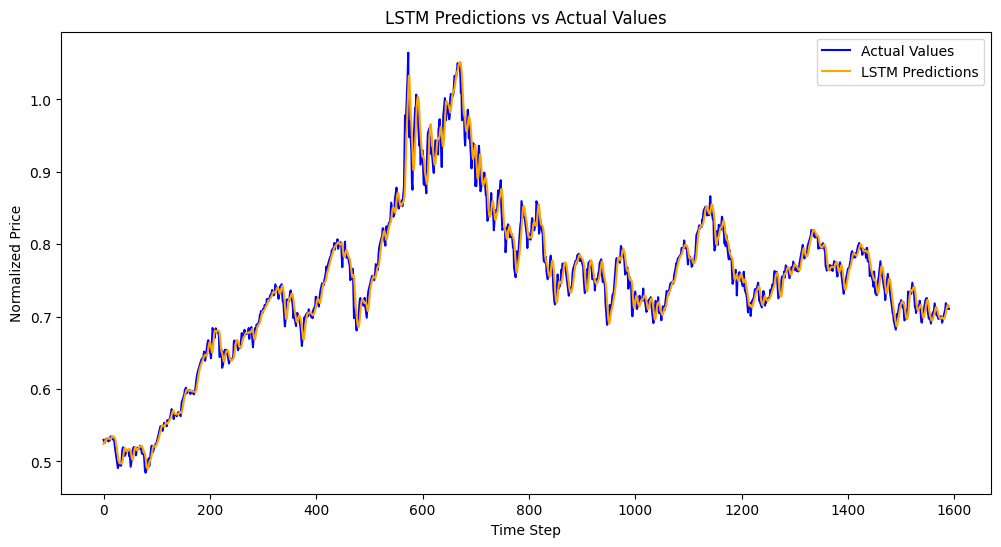

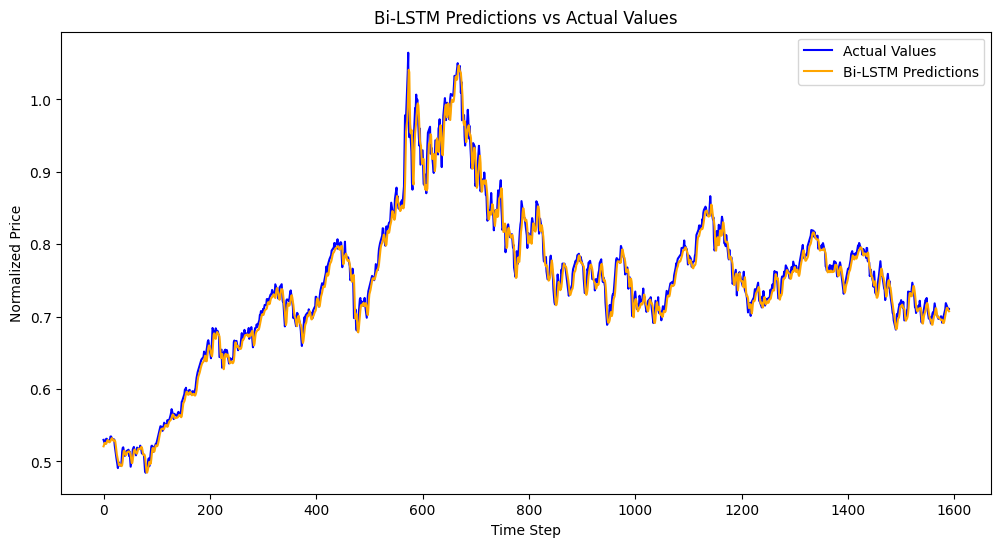

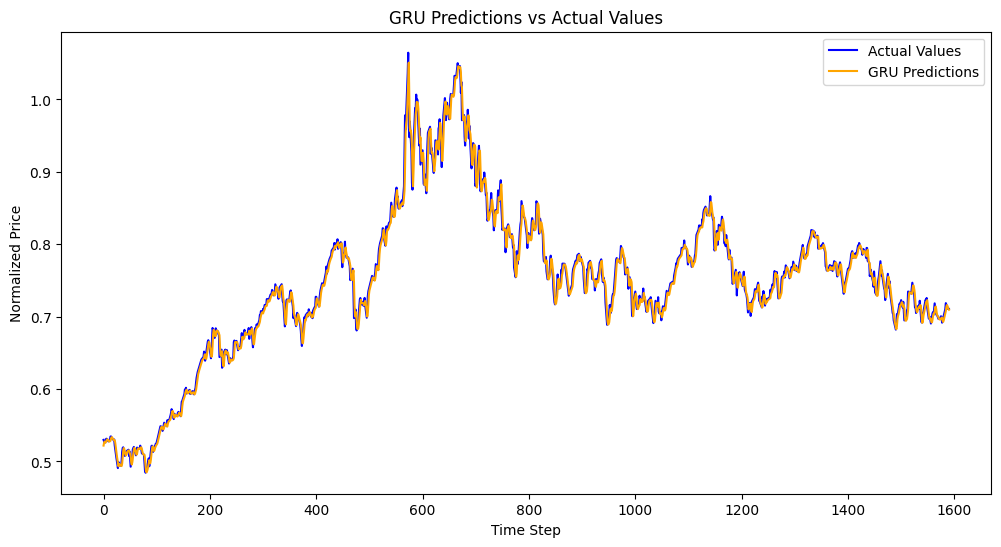

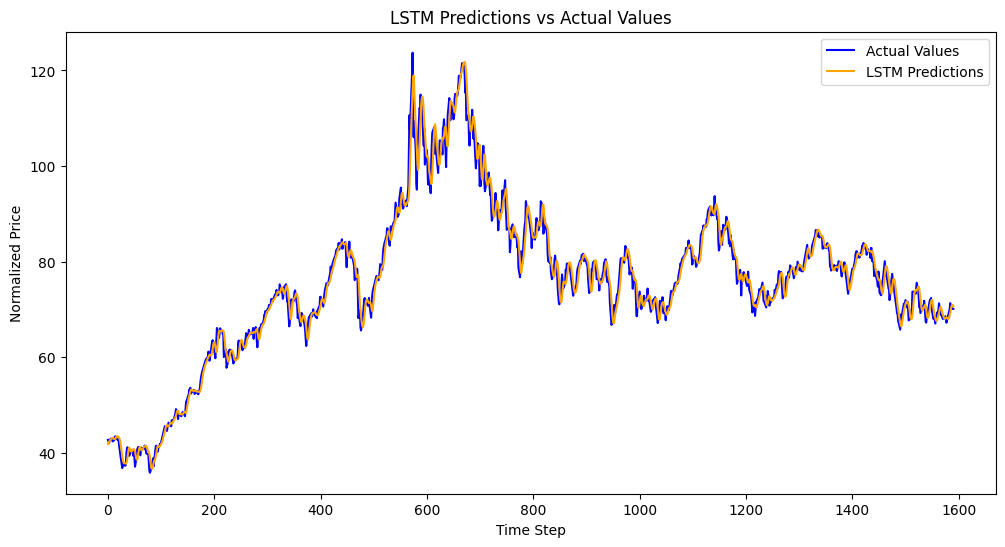

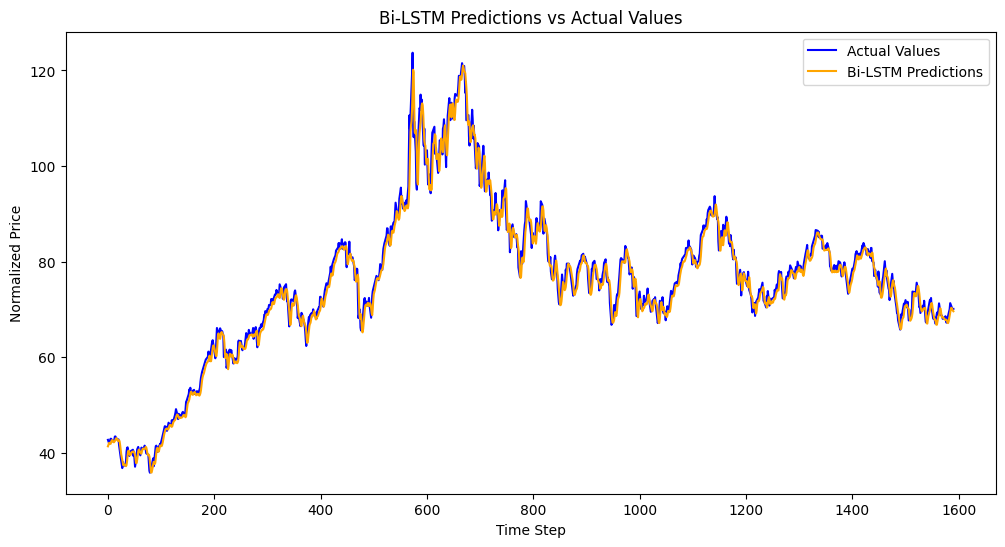

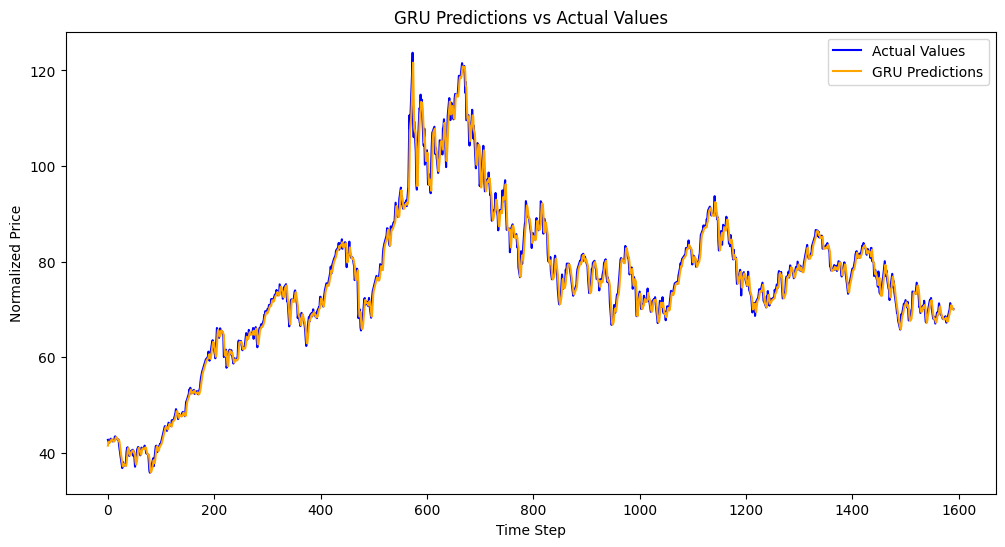

In [14]:
# Generate predictions
lstm_predictions_scaled = lstm_model.predict(test_sequences)
bi_lstm_predictions_scaled = bi_lstm_model.predict(test_sequences)
gru_predictions_scaled = gru_model.predict(test_sequences)
actual_values = scaler.inverse_transform(test_targets.reshape(-1, 1))
# Convert predictions back to original scale
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
bi_lstm_predictions = scaler.inverse_transform(bi_lstm_predictions_scaled)
gru_predictions = scaler.inverse_transform(gru_predictions_scaled)

# Plot predictions vs actual values
def plot_predictions(predictions, actual, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Values', color='blue')
    plt.plot(predictions, label=f'{model_name} Predictions', color='orange')
    plt.title(f'{model_name} Predictions vs Actual Values')
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.show()

plot_predictions(lstm_predictions_scaled, test_targets, 'LSTM')
plot_predictions(bi_lstm_predictions_scaled, test_targets, 'Bi-LSTM')
plot_predictions(gru_predictions_scaled, test_targets, 'GRU')
plot_predictions(lstm_predictions, actual_values, 'LSTM')
plot_predictions(bi_lstm_predictions, actual_values, 'Bi-LSTM')
plot_predictions(gru_predictions, actual_values, 'GRU')

### 📊 3.2 Error Metrics
📌 Explain the following **error metrics** used in the paper:
- `RMSE` (Root Mean Square Error)
- `MAE` (Mean Absolute Error)
- `MAPE` (Mean Absolute Percentage Error)
- `R-Squared` (Coefficient of Determination)

📌 Compute these metrics for **each model** and **compare the results** with the paper.

🛠 *Your task:* Implement the evaluation metrics below.

In [15]:
# Metrics calculations
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def calculate_metrics(predictions, actual):
    mae = mean_absolute_error(actual, predictions)
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    r2 = r2_score(actual, predictions)
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mae, rmse, r2, mape

lstm_metrics_scaled = calculate_metrics(lstm_predictions_scaled, test_targets)
bi_lstm_metrics_scaled = calculate_metrics(bi_lstm_predictions_scaled, test_targets)
gru_metrics_scaled = calculate_metrics(gru_predictions_scaled, test_targets)
# Calculate metrics for unscaled data
lstm_metrics_unscaled = calculate_metrics(lstm_predictions, actual_values)
bi_lstm_metrics_unscaled = calculate_metrics(bi_lstm_predictions, actual_values)
gru_metrics_unscaled = calculate_metrics(gru_predictions, actual_values)


# Print metrics
print("LSTM Metrics (Scaled):", lstm_metrics_scaled)
print("Bi-LSTM Metrics (Scaled):", bi_lstm_metrics_scaled)
print("GRU Metrics (Scaled):", gru_metrics_scaled)
print("LSTM Metrics (Unscaled):", lstm_metrics_unscaled)
print("Bi-LSTM Metrics (Unscaled):", bi_lstm_metrics_unscaled)
print("GRU Metrics (Unscaled):", gru_metrics_unscaled)


LSTM Metrics (Scaled): (0.010500598878088999, 0.014798056948874063, 0.9808241346953824, 16.1273119586567)
Bi-LSTM Metrics (Scaled): (0.009796678027410834, 0.013453091493021355, 0.984151441275923, 16.01950690974525)
GRU Metrics (Scaled): (0.007450785467391785, 0.010686406151708641, 0.9899997942837199, 16.07001694184868)
LSTM Metrics (Unscaled): (1.5914708369886656, 2.242793522624053, 0.980824134847048, 2.0643870916344413)
Bi-LSTM Metrics (Unscaled): (1.4847848898206115, 2.038950794403296, 0.9841514377121109, 1.926832315806592)
GRU Metrics (Unscaled): (1.1292412855179095, 1.619631823671901, 0.9899997931396907, 1.4681135233254263)


In [11]:
# Fill missing values for all features
filled_data = data.copy()
for column in ['Open', 'High', 'Low', 'Volume', 'Adj Close']:
    filled_data[column] = filled_data[column].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

# Split data into training and testing sets
train_data = filled_data.iloc[:-int(0.3 * len(filled_data))]
test_data = filled_data.iloc[-int(0.3 * len(filled_data)):]

# Define target and exogenous variables
train_target = train_data['Adj Close']
train_exog = train_data[['Open', 'High', 'Low', 'Volume']]
test_exog = test_data[['Open', 'High', 'Low', 'Volume']]

<ipython-input-11-375732122c1a>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_data[column] = filled_data[column].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


In [12]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_data['Adj Close'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")

if result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")

ADF Statistic: -1.3175200901257018
p-value: 0.6211192230668825
Critical Values: {'1%': -3.4320679607261453, '5%': -2.86229910063996, '10%': -2.5671740791451567}
The series is not stationary.


## 4️⃣ ARIMA Model 📉

📌 Explain the **difference** between `ARIMA` and `SARIMA` models.

📌 List the **advantages** and **limitations** of `ARIMA`.

📌 Explain the **mathematical formulation** of `ARIMA`, including its **parameters**.

📌 Determine the **optimal parameters** for `ARIMA` and **report the results**.

📌 Compare the results with **Table 6** from the paper.

📄 [Reference Paper](https://www.ijournalse.org/index.php/ESJ/article/view/21497)

🛠 *Your task:* Implement the ARIMA model below.

In [15]:
# Train ARIMA model using auto_arima
!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

arima_model = auto_arima(train_data['Adj Close'],exogenous=train_exog ,seasonal=False , trace=True, error_action='ignore', \
                         suppress_warnings=True, stepwise=True, max_d=4,  test="kpss", start_p=1, start_q=1,max_p=5, max_q=5,)
print(f"Optimal ARIMA Order: {arima_model.order}")

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13112.198, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13114.977, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13103.285, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13102.068, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13113.223, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13099.774, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13070.265, Time=0.67 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13043.542, Time=1.72 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13060.941, Time=0.80 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13038.415, Time=1.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=13037.178, Time=0.92 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=13038.639, Time=0.33 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=13038.854, Time=1.91 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13095.414, Time=0.28 sec
 ARIMA(4,1,0)(0,0,0

In [24]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from tqdm import tqdm
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="statsmodels")

arima_predictions = []
history = list(train_data['Adj Close'])
exog_history = train_data[['Open', 'High', 'Low', 'Volume']]

# Wrap the range with tqdm for progress tracking
for t in tqdm(range(len(test_data['Adj Close'])), desc="Processing ARIMA predictions"):
    model = ARIMA(history, exog=exog_history, order=(3, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1, exog=test_data[['Open', 'High', 'Low', 'Volume']].iloc[[t]]).iloc[0]
    arima_predictions.append(forecast)
    actual_ = test_data['Adj Close'].iloc[t]
    history.append(actual_)
    exog_history = pd.concat([exog_history, test_data[['Open', 'High', 'Low', 'Volume']].iloc[[t]]])


arima_metrics = calculate_metrics(arima_predictions, test_data['Adj Close'])
print("ARIMA Metrics (Unscaled):", arima_metrics)

Processing ARIMA predictions: 100%|██████████| 1640/1640 [19:52<00:00,  1.38it/s]

ARIMA Metrics (Unscaled): (0.8697098477810211, 1.3583054514301331, 0.9936417162303871, 1.1364695957188116)


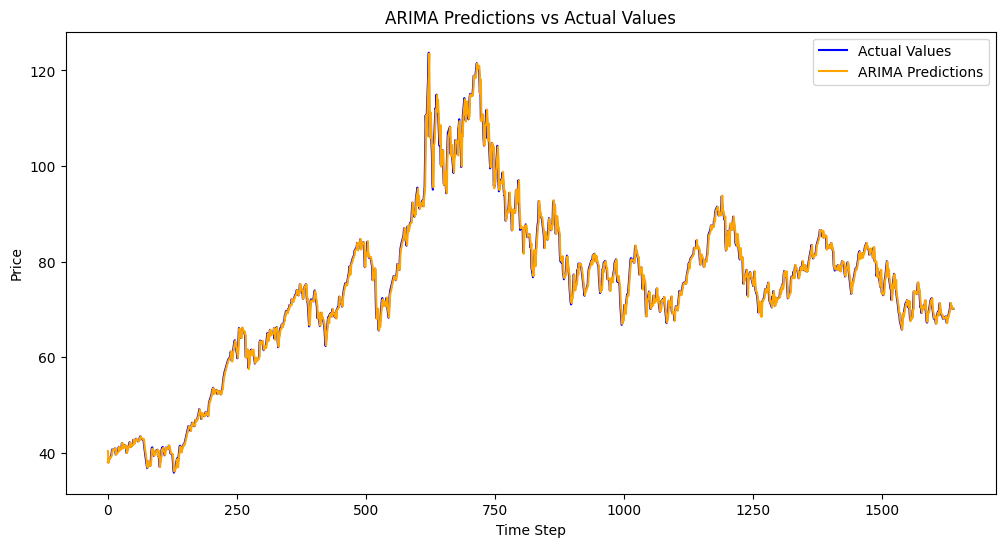

In [26]:
# Plot ARIMA vs actual
plt.figure(figsize=(12, 6))
plt.plot(test_data['Adj Close'].values, label='Actual Values', color='blue')
plt.plot(arima_predictions, label='ARIMA Predictions', color='orange')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [34]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
#P  = range(1, 4)  
#m = [12]  # Seasonality 
#D = Q = = range(2, 4)
# Generate all combinations of parameters
order_combinations = [(3,1,2)]
#seasonal_combinations = list(itertools.product(P, D, Q, m))
seasonal_combinations = [(3,1,1,12)]
# Initialize variables to store the best results
best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_model = None

# Grid search over all parameter combinations
for order in order_combinations:
    for seasonal_order in seasonal_combinations:
        try:
            # Train SARIMA model
            model = SARIMAX(
                train_data['Adj Close'],
                exog=train_exog,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=True,
                enforce_invertibility=True
            )
            model_fit = model.fit(disp=True)
            
            # Check AIC
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = model_fit
        except Exception as e:
            print(e)
            continue

print(f"Best SARIMA Model: Order={best_order}, Seasonal_Order={best_seasonal_order}, AIC={best_aic}")
print(best_model.summary())

Best SARIMA Model: Order=(3, 1, 2), Seasonal_Order=(3, 1, 1, 12), AIC=7945.564607934014
                                      SARIMAX Results                                       
Dep. Variable:                            Adj Close   No. Observations:                 3827
Model:             SARIMAX(3, 1, 2)x(3, 1, [1], 12)   Log Likelihood               -3958.782
Date:                              Sun, 22 Dec 2024   AIC                           7945.565
Time:                                      21:20:22   BIC                           8033.015
Sample:                                  01-01-2010   HQIC                          7976.638
                                       - 06-23-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open      

In [41]:
# Batch forecasting for SARIMA
sarima_predictions_recursive = []
current_input = train_target.iloc[-1]
current_exog = train_exog.iloc[-1].values.reshape(1, -1)
for i in range(len(test_data)):
    next_prediction = best_model.forecast(steps=1, exog=test_exog.iloc[i].values.reshape(1, -1)).iloc[0]
    sarima_predictions_recursive.append(next_prediction)

sarima_metrics = calculate_metrics(sarima_predictions_recursive, test_data['Adj Close'])
print("SARIMA without history Metrics (Batch):", sarima_metrics)

SARIMA without history Metrics (Batch): (10.669658451024176, 11.914894310768716, 0.5107561130989908, 13.238361239786137)


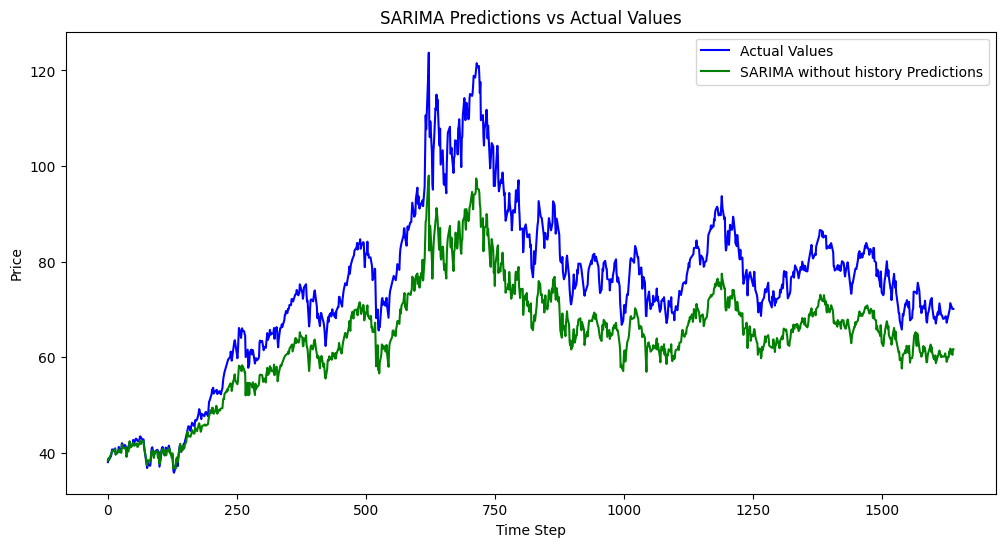

In [42]:
# Plot SARIMA vs actual
plt.figure(figsize=(12, 6))
plt.plot(test_data['Adj Close'].values, label='Actual Values', color='blue')
plt.plot(sarima_predictions_recursive, label='SARIMA without history Predictions', color='green')
plt.title('SARIMA Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()
